<a href="https://colab.research.google.com/github/caltech-netlab/datacenter-voltage-control/blob/master/Decentralized_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/250805 data center

/content/drive/MyDrive/Colab Notebooks/250805 data center


In [5]:
import scipy.io
import random
import math
import scipy.io as sio
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt
import collections
from mpl_toolkits.mplot3d import Axes3D
import gym
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import sys
from gym import spaces
from gym.utils import seeding
import copy
from tensorflow.keras import layers
from tensorflow import keras
import time
import cvxpy as cp
import pickle
from numpy import linalg as LA
# !pip install mat4py
# from mat4py import loadmat

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Environment Setup

## Generate profile for v0

In [7]:
!andes misc -C


/bin/bash: line 1: andes: command not found


In [8]:
    import sys
    from pathlib import Path

    # Define the path to the directory containing your .py file
    # Replace 'MyModules' with the actual folder name in your Google Drive
    src_dir = Path('/content/drive/MyDrive/Colab Notebooks/250805 data center')

    # Add the path to sys.path if it's not already there
    try:
        sys.path.index(str(src_dir))
    except ValueError:
        sys.path.insert(0, str(src_dir))

In [9]:
!python3 -m pip install andes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for andes: filename=andes-1.9.3-py3-none-any.whl size=3447010 sha256=a2da2

In [10]:
import os
import json
import hashlib
from tqdm import tqdm
import andes

# import load_data
# from visualize import *
# from data.circuit_data import *
np.set_printoptions(precision=3)
np.set_printoptions(threshold=10000)
np.set_printoptions(linewidth=200)
DT = 5e-3


In [11]:

"""

Per-unit impedance for PWP transformers:
1. 34.4kV:4.36kV
New Transformer.Del_D1_Mar_D1_1B Phases=3 Windings=2 XHL=6.55936480
~ wdg=1 bus=Del_D1_Mar_D1_East.1.2.3 conn=delta kV=34.399998 kva=3750.00000000 %R=0.36562806
~ wdg=2 bus=Del_D1_Mar_D1_1B.1.2.3.0 conn=wye kV=4.360000 kva=3750.00000000 %R=0.36562806
Z_pu = 0.003656+j0.06559
2. 2.4kV:240V
New Transformer.TR_V8957-0_B Phases=1 Windings=2 XHL=1.99557030
~ wdg=1 bus=UG687584.2.0 conn=wye kV=2.401777 kva=100.00000000 %R=0.06651906
~ wdg=2 bus=TR_V8957-0.2.0 conn=wye kV=0.240000 kva=100.00000000 %R=0.06651906
Z _pu = 0.000665+j0.0346
3. 16kV:240V
New Transformer.TR_V6627-402408_AB Phases=1 Windings=2 XHL=4.98892593
~ wdg=1 bus=UG10167.1.2 conn=delta kV=16.340000 kva=300.00000000 %R=0.16629764
~ wdg=2 bus=TR_V6627-402408.1.2 conn=delta kV=0.240000 kva=300.00000000 %R=0.16629764
Z_pu = 0.004988+j0.1663

https://www.eng-tips.com/threads/typical-transmission-line-parameters.65375/?utm_source=chatgpt.com
NOMINAL VOLTAGE CLASS (kV)    R (Ω/mi)          X (Ω/mi)    B (μmho/mi)
138                           0.10 to 0.25      0.60        4.5
230                           0.05 to 0.10      0.50        5.5
345                           0.03 to 0.05      0.40        6.0
500                           0.02 to 0.04      0.30        6.5

p.22, IA State, EE456 Transmission Line Design Information: Drive.google.com/drive/u/1/folders/0BzFTyjxorIWAeFo0dWtqVFRrb1k?resourcekey=0-sBzhb8ZPfbgfwJkWnte2Eg
Nominal_Voltage_kV    System_Strength_MVA3φ    Percent_X    Z_percent_per_mi          Y_percent_per_mi    SIL_MW
345                   30000                    0.333        0.00571+j0.06432        j0.6604             320
765                   66000                    0.151        0.00033+j0.00918        j4.689              2250
1100                  95000                    0.105        0.00007+j0.00598        j10.69              5180
1500                  130000                   0.077        0.00003+j0.00207        j20.51              9940

ChatGPT based on Kersting's "Distribution System Modeling"
Voltage_kV    R_ohm_per_km      X_ohm_per_km      B_uS_per_km    X/R_ratio
23            0.30 to 0.50      0.15 to 0.25      1 to 3         2 to 4
13.8          0.40 to 0.60      0.20 to 0.30      0.8 to 2       2 to 3
12.47         0.45 to 0.65      0.22 to 0.33      0.7 to 1.8     2 to 3
4.16          0.80 to 1.50      0.35 to 0.70      0.2 to 0.5     2 to 3
0.48 (480 V)  3.00 to 5.00      0.50 to 1.20      ~0            1 to 2

"""
"""
Conventions
- All power values are in MW or MVar
- Positive nodal power injection is defined as out of a node

"""


# System S_base = 1 MVA, V_base = 345kV, 16kV, 240V
# Z_base = V_base^2 / S_base = <not needed>
vulcan_circuit_data1 = [
    {
        'element_name': 'line_grid_utility_a_pri',
        'source': 'interconnection_a',
        'target': 'utility_a_pri',
        'series_impedance': 0.000571+0.006432j,           # 345kV line, 10 mile, in p.u.
    },
    {
        'element_name': 'tr_utility_a_mv',
        'source': 'utility_a_pri',
        'target': 'mv_distribution_bus',
        'series_impedance': 0.00003656+0.0006559j,      # 100MVA rating, in p.u.
    },
    {
        'element_name': 'tr_mv_bat_1',
        'source': 'mv_distribution_bus',
        'target': 'batt_1_sec',
        'series_impedance': 0.0001+0.003326j,           # 50MVA rating
    },
    {
        'element_name': 'tr_mv_bat_2',
        'source': 'mv_distribution_bus',
        'target': 'batt_2_sec',
        'series_impedance': 0.0002494+0.008315j,        # 20MVA rating
    },
    {
        'element_name': 'tr_mv_cooling_1',
        'source': 'mv_distribution_bus',
        'target': 'cooling_1_sec',
        'series_impedance': 0.0002494+0.008315j,        # 20MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_1',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_1_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_2',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_2_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
]

vulcan_bus_data1 = {
    'interconnection_a': {'qmin': 0, 'qmax': 0, 'type': 'grid'},
    'utility_a_pri': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'mv_distribution_bus': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'batt_1_sec': {'qmin': -25, 'qmax': 25, 'pmin': -50, 'pmax': 50, 'type': 'battery'},
    'batt_2_sec': {'qmin': -25, 'qmax': 25, 'pmin': -50, 'pmax': 20, 'type': 'battery'},
    'cooling_1_sec': {'qmin': 0, 'qmax': 2, 'pmin': 0, 'pmax': 20, 'p_rating': 20, 'type': 'cooling'},
    'datacenter_1_sec': {'qmin': -20, 'qmax': 20, 'pmax': 25, 'type': 'compute'},
    'datacenter_2_sec': {'qmin': -20, 'qmax': 20, 'pmax': 25, 'type': 'compute'},
}

vulcan_circuit_data2 = [
    {
        'element_name': 'line_grid_utility_a_pri',
        'source': 'interconnection_a',
        'target': 'utility_a_pri',
        'series_impedance': 5e-5 + 5e-4j,              # 765kV line, ~0.1 mile, in p.u.
    },
    {
        'element_name': 'tr_utility_a_mv',
        'source': 'utility_a_pri',
        'target': 'mv_distribution_bus',
        'series_impedance': 9.14e-06+0.000163975j,      # 400MVA rating, in p.u.
    },
    {
        'element_name': 'tr_mv_bat_1',
        'source': 'mv_distribution_bus',
        'target': 'batt_1_sec',
        'series_impedance': 5e-05+0.001663j,            # 100MVA rating
    },
    {
        'element_name': 'tr_mv_bat_2',
        'source': 'mv_distribution_bus',
        'target': 'batt_2_sec',
        'series_impedance': 5e-05+0.001663j,            # 100MVA rating
    },
    {
        'element_name': 'tr_mv_cooling_1',
        'source': 'mv_distribution_bus',
        'target': 'cooling_1_sec',
        'series_impedance': 6.235e-05+0.00207875j,        # 20MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_1',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_1_sec',
        'series_impedance': 0.0001195+0.004652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_2',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_2_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_3',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_3_sec',
        'series_impedance': 0.0001095+0.003652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_4',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_4_sec',
        'series_impedance': 0.0001495+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_5',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_5_sec',
        'series_impedance': 0.0001195+0.004652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_6',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_6_sec',
        'series_impedance': 0.0001295+0.003652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_7',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_7_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_8',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_8_sec',
        'series_impedance': 0.0001+0.003652j,        # 25MVA rating
    },
]

vulcan_bus_data2 = {
    'interconnection_a': {'qmin': 0, 'qmax': 0, 'type': 'grid'},
    'utility_a_pri': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'mv_distribution_bus': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'batt_1_sec': {'qmin': -20, 'qmax': 20, 'pmin': -20, 'pmax': 20, 'type': 'battery'},
    'batt_2_sec': {'qmin': -20, 'qmax': 20, 'pmin': -20, 'pmax': 20, 'type': 'battery'},
    'cooling_1_sec': {'qmin': 0, 'qmax': 8, 'pmin': 0, 'pmax': 80, 'p_rating': 80, 'type': 'cooling'},
    'datacenter_1_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_2_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_3_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_4_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_5_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_6_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_7_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_8_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
}

vulcan_circuit_data3 = [
    {
        'element_name': 'line_grid_utility_a_pri',
        'source': 'interconnection_a',
        'target': 'utility_a_pri',
        'series_impedance': 5e-5 + 5e-4j,              # 765kV line, ~0.1 mile, in p.u.
    },
    {
        'element_name': 'tr_utility_a_mv',
        'source': 'utility_a_pri',
        'target': 'mv_distribution_bus',
        'series_impedance': 9.14e-06+0.000163975j,      # 400MVA rating, in p.u.
    },
    {
        'element_name': 'tr_mv_cooling_1',
        'source': 'mv_distribution_bus',
        'target': 'cooling_1_sec',
        'series_impedance': 6.235e-05+0.00207875j,      # 20MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_1',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_1_sec',
        'series_impedance': 0.0001195+0.004652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_2',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_2_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_3',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_3_sec',
        'series_impedance': 0.0001095+0.003652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_4',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_4_sec',
        'series_impedance': 0.0001495+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_5',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_5_sec',
        'series_impedance': 0.0001195+0.004652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_6',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_6_sec',
        'series_impedance': 0.0001295+0.003652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_7',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_7_sec',
        'series_impedance': 0.0001995+0.006652j,        # 25MVA rating
    },
    {
        'element_name': 'tr_mv_datacenter_8',
        'source': 'mv_distribution_bus',
        'target': 'datacenter_8_sec',
        'series_impedance': 0.0001+0.003652j,        # 25MVA rating
    },
]

vulcan_bus_data3 = {
    'interconnection_a': {'qmin': 0, 'qmax': 0, 'type': 'grid'},
    'utility_a_pri': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'mv_distribution_bus': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'cooling_1_sec': {'qmin': 0, 'qmax': 8, 'pmin': 0, 'pmax': 80, 'p_rating': 80, 'type': 'cooling'},
    'datacenter_1_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_2_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_3_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_4_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_5_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_6_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_7_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
    'datacenter_8_sec': {'qmin': -5, 'qmax': 5, 'pmin': -5, 'pmax': 5, 'p_rating': 20,'type': 'compute'},
}

"""No real power control"""
vulcan_bus_data4 = {
    'interconnection_a': {'qmin': 0, 'qmax': 0, 'type': 'grid'},
    'utility_a_pri': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'mv_distribution_bus': {'qmin': 0, 'qmax': 0, 'type': 'internal'},
    'batt_1_sec': {'qmin': -20, 'qmax': 20, 'pmin': 0, 'pmax': 0, 'type': 'battery'},
    'batt_2_sec': {'qmin': -20, 'qmax': 20, 'pmin': 0, 'pmax': 0, 'type': 'battery'},
    'cooling_1_sec': {'qmin': 0, 'qmax': 8, 'pmin': 0, 'pmax': 80, 'p_rating': 80, 'type': 'cooling'},
    'datacenter_1_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
    'datacenter_2_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
    'datacenter_3_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
    'datacenter_4_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
    'datacenter_5_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
    'datacenter_6_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
    'datacenter_7_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
    'datacenter_8_sec': {'qmin': -5, 'qmax': 5, 'pmin': 0, 'pmax': 0, 'p_rating': 20, 'type': 'compute'},
}

In [12]:
import pandas as pd
import scipy as sp
import networkx as nx

import utils
from data.circuit_data import *


def single_phase_lindistflow(circuit_data, node_list=None):
    """
    An implementation of the single-phase LinDistFlow is provided for reference.
    Note that the R, X values are averaged (not summed) across the three phases.
    :param circuit_data: dict, edge list, e.g.
        [
            {
                'element_name': 'line_1',
                'source': 'bus_1',
                'target': 'bus_2',
                'series_impedance': complex,
            },
            ...
        ]
    :param per_unit: bool, if True, convert all quantities to per-unit
        Only p.u. is supported for now.
    :param s_base: float, base power for per-unit conversion
    return: R_matrix, X_matrix, C_matrix, node_list
        R_matrix: np.array, shape=(N, N)
        X_matrix: np.array, shape=(N, N)
        C_matrix: np.array, shape=(N+1, N)
        node_list: list of str, node names
        Usage:
            nodal_voltages = v0 + 2 * (R_matrix @ p_inj[1:] + X_matrix @ q_inj[1:])
            branch_power = np.linalg.inv(C_matrix[1:, :]) @ (p + 1j * q)
    """
    edge_list = utils.to_edge_list(circuit_data)
    graph = nx.DiGraph(edge_list)
    root_node = [n for n in graph.nodes if graph.in_degree(n) == 0]
    assert len(root_node) == 1, f"There should be only one root node: {root_node}"
    assert nx.is_directed_acyclic_graph(graph), "Graph contains a cycle. Only radial networks are supported."
    N = len(graph.nodes) - 1    # Excluding the root node
    assert len(graph.edges) == N, len(graph.edges)
    # Build node_list and assign node id
    node_list = node_list or list(nx.bfs_tree(graph, root_node[0]).nodes())
    assert node_list[0] == root_node[0], f"Root node {node_list[0]} does not match {root_node[0]}"
    node2idx = {node: k for k, node in enumerate(node_list)}
    # Replace node names with integer indicies
    edge_list = [(node2idx[e[0]], node2idx[e[1]]) for e in edge_list]
    graph = nx.DiGraph(edge_list)
    # Check that the node_list is in BFS or DFS order
    for i in range(1, N+1):
        assert not (set(graph.predecessors(i)) - set(range(i))), \
            str('\n'.join([n.split('|')[0] for n in node_list]) + '\n' + str(set(graph.predecessors(i))) + ' ' + str(i))

    # Careful! The graph needs to be in the down orientation.
    # networkx incidence_matrix has the opposite sign convention
    C_matrix = -nx.incidence_matrix(graph, oriented=True, nodelist=list(range(N+1))).toarray()
    ge = list(graph.edges)
    permutation = [ge.index((i, j)) for i, j in edge_list]
    C_matrix = C_matrix[:, permutation]
    C_inv = np.linalg.inv(C_matrix[1:])
    utils.plot_nx_graph(
        graph,
        node_info={i: n.split('|')[0] for i, n in enumerate(node_list)},
        outpath='temp/network.png',
        edge_info={e: circuit_data[i]['series_impedance'] for i, e in enumerate(edge_list)},
    )

    resistances, reactances = np.zeros(N), np.zeros(N)
    for edge in circuit_data:
        e = edge_list.index((node2idx[edge['source']], node2idx[edge['target']]))
        resistances[e] = edge['series_impedance'].real
        reactances[e] = edge['series_impedance'].imag
    R_matrix = C_inv.T @ np.diag(resistances) @ C_inv
    X_matrix = C_inv.T @ np.diag(reactances) @ C_inv
    return R_matrix, X_matrix, C_matrix, node_list, edge_list


def load_compute_power(file, t0, t1, keys):
    """
    :param file: str, path to the csv file
    :param t0: str, start time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param t1: str, end time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param keys: dict, e.g. {'t': 'timestamp', 'p': 'power.draw [W]'}
    :return: dict with keys 't' (float seconds) and 'power_factor' (per-unit power)
    """
    # Read CSV with timestamp parsing
    df = pd.read_csv(file, parse_dates=[keys['t']])
    # Convert t0, t1 to datetime
    t0_dt = pd.to_datetime(t0)
    t1_dt = pd.to_datetime(t1)
    # Filter by time range
    mask = (df[keys['t']] >= t0_dt) & (df[keys['t']] <= t1_dt)
    df = df.loc[mask, [keys['t'], keys['p']]].copy()
    # Rename columns to standardized names
    df.rename(columns={keys['t']: 't', keys['p']: 'power'}, inplace=True)
    # Compute per-unit power
    max_p = df['power'].max()
    df['power_factor'] = df['power'] / max_p
    # Reset time to start from zero (in seconds)
    df['t'] = (df['t'] - df['t'].iloc[0]).dt.total_seconds()
    # Return dictionary of arrays
    return {'t': df['t'].to_numpy(), 'compute_power_factor': df['power_factor'].to_numpy()}


def load_v0(file, keys, dt, gen_idx=0, test_idx=0):
    """
    Wenqi's mat/pickle file format:
        array[test_idx,0,:,:]
        time = dt*np.arange(0,np.shape(voltage)[-1])
        the test_idx is different outages, the second column is the index for variable, where 0 is voltage

    :param file: str, path to the csv file
    :param t0: str, start time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param t1: str, end time in 'YYYY/MM/DD HH:MM:SS.sss'
    :param keys: dict, e.g. {'t': 'timestamp', 'v0': 'voltage [V]'}
    :return: dict with keys 't' (float seconds) and 'v0' (voltage)
    """
    # Read CSV with timestamp parsing
    if file.endswith('.mat'):
        df = sp.io.loadmat(file)
        df = pd.DataFrame({'v0': df[keys['v0']][test_idx, 0, gen_idx]})
    elif file.endswith('.pckl'):
        array = pd.read_pickle(file)[0]
        df = pd.DataFrame({'v0': array[test_idx, 0, gen_idx]})
    else:
        raise ValueError("Unsupported file format")

    # Create time column
    df['t'] = dt * np.arange(0, len(df['v0']))

    # Return dictionary of arrays
    return {'t': df['t'].to_numpy(), 'v0': df['v0'].to_numpy()}


def align_data(data, dt, t_start=0, t_end=None):
    """
    Align multiple datasets by a common time base using linear interpolation.
    :param data: dict of named dicts, each with keys 't' and one other data array
    :param resample_interval: float, time step in seconds for interpolation
    :return: None (data is modified in place)
    """
    aligned_data = {}
    # Determine intersection of time ranges
    starts = []
    ends = []
    for entry in data.values():
        t_arr = np.array(entry['t'], dtype=float)
        starts.append(t_arr[0])
        ends.append(t_arr[-1])
    t_start = t_start or max(starts)
    t_end = t_end or min(ends)
    # Create new common time vector
    aligned_data['t'] = np.arange(t_start, t_end, dt)
    # Interpolate each series onto new time base
    for name, entry in data.items():
        # Identify data field (exclude 't')
        for k, v in entry.items():
            if k == 't':
                continue
            # Linear interpolation
            aligned_data[k] = np.interp(aligned_data['t'], entry['t'], v)
    return aligned_data


if __name__ == "__main__":
    R_matrix, X_matrix, C_matrix, node_list, edge_list = single_phase_lindistflow(vulcan_circuit_data2)
    print("R_matrix:", R_matrix.shape)
    print("X_matrix:", X_matrix.shape)
    print("C_matrix:", C_matrix.shape)
    print("Edge list:", len(edge_list))
    print("Node list:", len(node_list))

    file = 'data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv'
    t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:42:22.703'
    keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
    compute_power = load_compute_power(file, t0, t1, keys)

    file = 'data/record_trajectory_LossGen.mat'
    keys = {'v0': 'record_trajectory'}
    dt = 5e-3  # Resample interval in seconds
    v0 = load_v0(file, keys, dt)

    data = {'compute_power': compute_power, 'v0': v0}
    resample_dt = 1e-2
    aligned_data = align_data(data, resample_dt)
    for k, v in aligned_data.items():
        print(f"{k}: {v.shape}")

graphviz not installed or error. Using spring layout.
R_matrix: (13, 13)
X_matrix: (13, 13)
C_matrix: (14, 13)
Edge list: 13
Node list: 14
t: (500,)
compute_power_factor: (500,)
v0: (500,)


In [13]:
%matplotlib inline


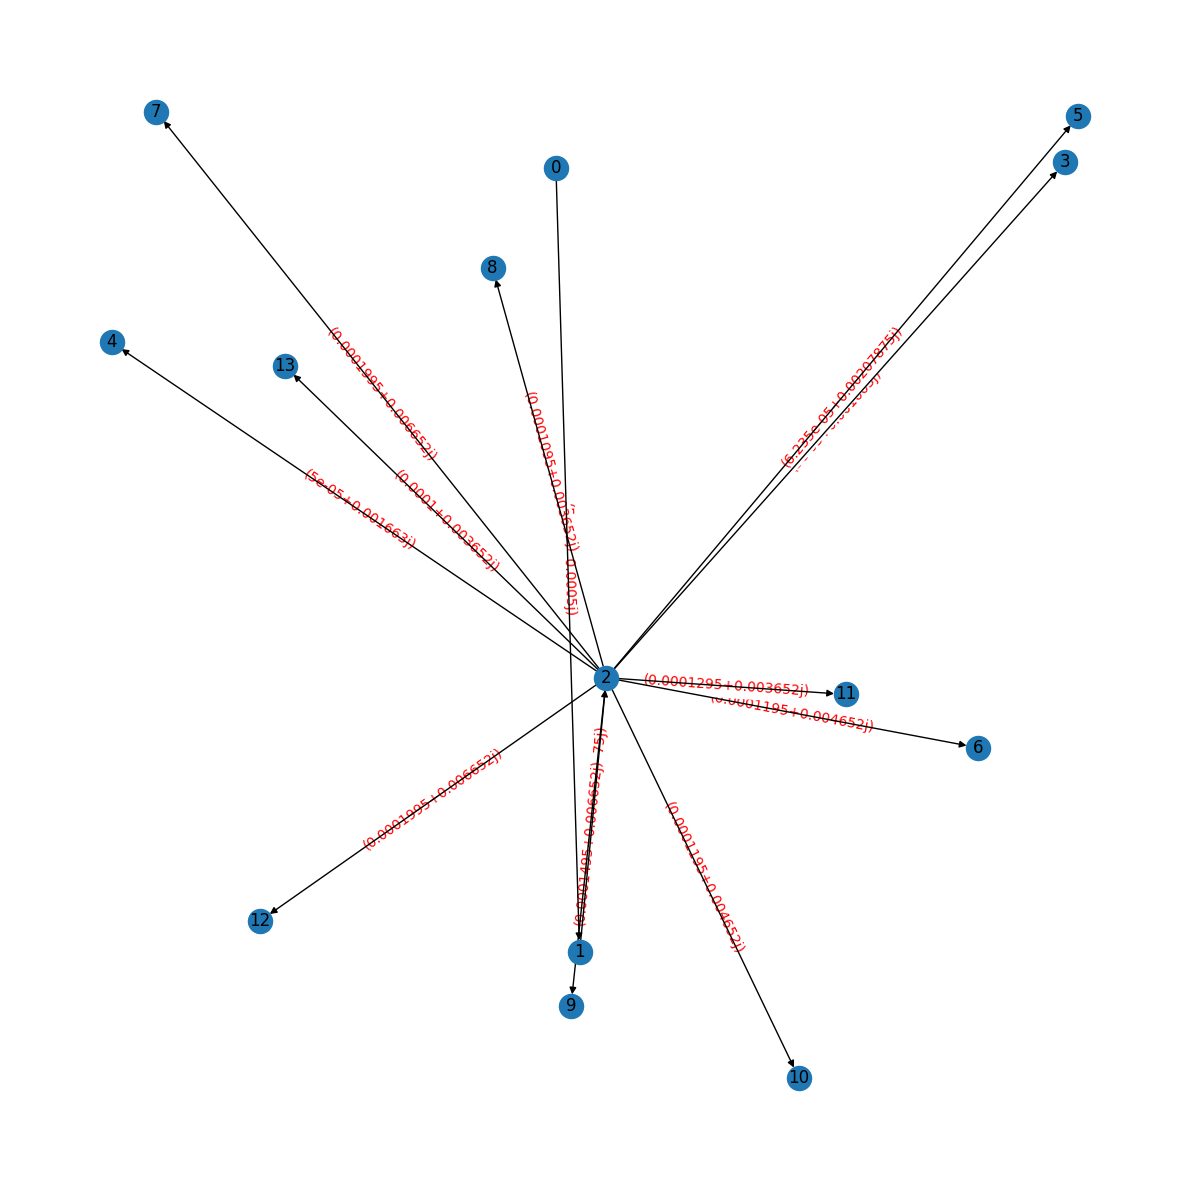

In [14]:
import os
import re
import matplotlib.pyplot as plt

ORANGE = [1.00, 0.43, 0.12]
plt.rcParams['font.family'] = 'Times New Roman'


def _labelize(name: str) -> str:
    # Extend or edit as needed
    LABEL_OVERRIDES = {
        # Example explicit mappings (these take precedence over pattern rules)
        # "batt_1_sec": "battery 1",
        # "cooling_2_sec": "cooling 2",
        # "datacenter_3_sec": "compute cluster 3",
    }

    # Pattern-based renaming
    _PATTERNS = [
        (re.compile(r"^batt_(\d+)_sec$"),       r"Battery \1"),
        (re.compile(r"^cooling_(\d+)_sec$"),    r"Cooling \1"),
        (re.compile(r"^datacenter_(\d+)_sec$"), r"IT Cluster \1"),
    ]


def plot_simulation_2x2(
    sim_results,
    filename,
    nodes_to_plot=None,
    plot_ctrl=False,
    out_path='temp',
    ext=('pdf',),
    title=None,
    figsize=(12, 6),
    v_ylim=(0.7, 1.3),
    EXCLUDED_BUS_NAMES={"interconnection_a", "utility_a_pri", "mv_distribution_bus"},
    CONTROL_Y_LIM=(-10, 10),
    INJ_Y_LIM=(-5, 35)
):
    t = sim_results['t']
    node_list = sim_results['node_list'][1:]  # skip slack bus
    N = sim_results['v_solution'].shape[0]

    if not nodes_to_plot:
        # default: first up-to-10 nodes, excluding excluded names
        nodes_to_plot = [i for i in range(N) if node_list[i] not in EXCLUDED_BUS_NAMES][:12]
    else:
        # filter out excluded names if indices were provided
        nodes_to_plot = [i for i in range(N) if node_list[i] not in EXCLUDED_BUS_NAMES and node_list[i] in nodes_to_plot]

    # 2x2 layout:
    # (0,0) slack bus voltage
    # (0,1) voltages
    # (1,0) P
    # (1,1) Q
    fig, axes = plt.subplots(2, 2, figsize=figsize, constrained_layout=False)
    if title: fig.suptitle(title)
    ax_slack   = axes[0, 0]
    ax_V       = axes[0, 1]
    ax_P       = axes[1, 0]
    ax_Q       = axes[1, 1]

    # Slack bus voltage (top-left)
    ax_slack.plot(t, sim_results['v0'], label='v0 (slack bus)', color='black')
    ax_slack.set_xlabel("Time (s)")
    ax_slack.set_ylabel("Transmission Interconnection Node Voltage (p.u.)")
    ax_slack.grid(True, alpha=0.3)
    ax_slack.set_ylim(v_ylim)

    # Voltages (top-right)
    handles = []
    labels = []
    for i in nodes_to_plot:
        raw_label = node_list[i]
        lbl = _labelize(raw_label)
        h, = ax_V.plot(t, sim_results['v_solution'][i, :], label=lbl)
        handles.append(h)
        labels.append(lbl)
    ax_V.set_xlabel("Time (s)")
    ax_V.set_ylabel("Data Center Nodal Voltages (p.u.)")
    ax_V.grid(True, alpha=0.3)
    ax_V.set_ylim(v_ylim)

    # P (bottom-left)
    for i in nodes_to_plot:
        lbl = _labelize(node_list[i])
        if plot_ctrl:
            p_control_action = sim_results['p_inj'][i, :] - sim_results['p_nominal'][i, :]
            ax_P.plot(t, p_control_action, label=lbl)
        else:
            ax_P.plot(t, sim_results['p_inj'][i, :], label=lbl)
    ax_P.set_xlabel("Time (s)")
    ax_P.set_ylabel("Real Power Control (MW)" if plot_ctrl else "Real Power Injection (MW)")
    ax_P.grid(True, alpha=0.3)
    ax_P.set_ylim(CONTROL_Y_LIM if plot_ctrl else INJ_Y_LIM)

    # Q (bottom-right)
    for i in nodes_to_plot:
        lbl = _labelize(node_list[i])
        if plot_ctrl:
            q_control_action = sim_results['q_inj'][i, :] - sim_results['q_nominal'][i, :]
            ax_Q.plot(t, q_control_action, label=lbl)
        else:
            ax_Q.plot(t, sim_results['q_inj'][i, :], label=lbl)
    ax_Q.set_xlabel("Time (s)")
    ax_Q.set_ylabel("Reactive Power Control (MVar)" if plot_ctrl else "Reactive Power Injection (MVar)")
    ax_Q.grid(True, alpha=0.3)
    ax_Q.set_ylim(CONTROL_Y_LIM if plot_ctrl else INJ_Y_LIM)

    # Add vertical "Grid Fault" line at t=1s on all subplots
    for ax in [ax_slack, ax_V, ax_P, ax_Q]:
        ax.axvline(1, color='red', linestyle='--', alpha=0.5, linewidth=1)
        # Place the label slightly above the axis center
        ylim = ax.get_ylim()
        y_pos = ylim[0] + 0.7 * (ylim[1] - ylim[0])
        ax.text(1.02, y_pos, "Grid Fault", color='red', rotation=90, va='bottom')

    # Single legend outside on the right
    fig.subplots_adjust(right=0.80)
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.82, 0.5), borderaxespad=0.)

    os.makedirs(out_path, exist_ok=True)
    for fmt in ext:
        plt.savefig(os.path.join(out_path, f"{filename}.{fmt}"), bbox_inches='tight', dpi=300)
    plt.close(fig)


def plot_simulation(
    sim_results,
    filename,
    nodes_to_plot=None,
    plot_ctrl=False,
    out_path='temp',
    ext=('pdf',),
    title=None,
    figsize=(10, 12),
    v_ylim=(0.7, 1.3),
    EXCLUDED_BUS_NAMES={"interconnection_a", "utility_a_pri", "mv_distribution_bus"},
    CONTROL_Y_LIM=(-8, 8),
    INJ_Y_LIM=(-5, 35),
    fontsize=22
):

    plt.rcParams['font.size'] = fontsize  # sets the default font size
    # plt.rcParams['axes.titlesize'] = fontsize
    # plt.rcParams['axes.labelsize'] = fontsize
    # plt.rcParams['xtick.labelsize'] = fontsize
    # plt.rcParams['ytick.labelsize'] = fontsize
    # plt.rcParams['legend.fontsize'] = fontsize

    t = sim_results['t']
    node_list = sim_results['node_list'][1:]  # skip slack bus
    N = sim_results['v_solution'].shape[0]

    if not nodes_to_plot:
        nodes_to_plot = [i for i in range(N) if node_list[i] not in EXCLUDED_BUS_NAMES][:12]
    else:
        nodes_to_plot = [i for i in range(N) if node_list[i] not in EXCLUDED_BUS_NAMES and node_list[i] in nodes_to_plot]

    # 3x1 layout:
    # (0) slack + nodal voltages
    # (1) P
    # (2) Q
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    if title:
        fig.suptitle(title)
    ax_V_all = axes[0]
    ax_P = axes[1]
    ax_Q = axes[2]

    # Slack bus voltage (black) + Nodal voltages
    h, = ax_V_all.plot(t, sim_results['v0'], label='Grid', color='black', linewidth=2)
    handles = [h]
    labels = ['Grid']
    for i in nodes_to_plot:
        raw_label = node_list[i]
        lbl = _labelize(raw_label)
        h, = ax_V_all.plot(t, sim_results['v_solution'][i, :], label=lbl)
        handles.append(h)
        labels.append(lbl)
    # ax_V_all.set_xlabel("Time (s)")
    ax_V_all.set_xticklabels([])
    ax_V_all.set_ylabel("Voltage (per unit)")
    ax_V_all.grid(True, alpha=0.3)
    ax_V_all.set_ylim(v_ylim)

    # P subplot
    for i in nodes_to_plot:
        lbl = _labelize(node_list[i])
        if plot_ctrl:
            p_control_action = sim_results['p_inj'][i, :] - sim_results['p_nominal'][i, :]
            ax_P.plot(t, p_control_action, label=lbl)
        else:
            ax_P.plot(t, sim_results['p_inj'][i, :], label=lbl)
    # ax_P.set_xlabel("Time (s)")
    ax_P.set_xticklabels([])
    ax_P.set_ylabel("Real Power Control\n(MW)" if plot_ctrl else "Real Power Injection\n(MW)")
    ax_P.grid(True, alpha=0.3)
    ax_P.set_ylim(CONTROL_Y_LIM if plot_ctrl else INJ_Y_LIM)

    # Q subplot
    for i in nodes_to_plot:
        lbl = _labelize(node_list[i])
        if plot_ctrl:
            q_control_action = sim_results['q_inj'][i, :] - sim_results['q_nominal'][i, :]
            ax_Q.plot(t, q_control_action, label=lbl)
        else:
            ax_Q.plot(t, sim_results['q_inj'][i, :], label=lbl)
    ax_Q.set_xlabel("Time (s)")
    ax_Q.set_ylabel("Reactive Power Control\n(MVar)" if plot_ctrl else "Reactive Power Injection\n(MVar)")
    ax_Q.grid(True, alpha=0.3)
    ax_Q.set_ylim(CONTROL_Y_LIM if plot_ctrl else INJ_Y_LIM)

    # Add vertical "Grid Fault" line at t=1s on all subplots
    for ax in [ax_V_all, ax_P, ax_Q]: # ax_P, ax_Q
        ax.axvline(1, color='red', linestyle='--', alpha=0.5, linewidth=1)
    for ax in [ax_V_all]: # ax_P, ax_Q
        ylim = ax.get_ylim()
        y_pos = ylim[0] + 0.52 * (ylim[1] - ylim[0])
        ax.text(1.02, y_pos, "Grid Fault", color='red', rotation=90, va='bottom')

    # Legend at the bottom
    plt.tight_layout(h_pad=0.5)
    fig.subplots_adjust(bottom=0.25)
    fig.legend(
        handles, labels,
        loc='lower center',
        bbox_to_anchor=(0.49, 0.02),
        ncol=3,
        frameon=False,
        columnspacing=1
    )
    # # Single legend outside on the right


    os.makedirs(out_path, exist_ok=True)
    for fmt in ext:
        plt.savefig(os.path.join(out_path, f"{filename}.{fmt}"), bbox_inches='tight', dpi=300)
    plt.close(fig)


def plot_compute_load(p_rating=20, out_file='temp/compute_load.pdf'):
    plt.rcParams['font.size'] = 12  # sets the default font size
    # compute_pwr_file='data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv'
    # t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:41:39.473'
    # keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
    file = 'data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv'
    t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:42:22.703'
    keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
    compute_power = load_compute_power(file, t0, t1, keys)

    plt.figure(figsize=(5, 2))
    y_vals = compute_power['compute_power_factor'] * p_rating
    plt.plot(compute_power['t'], y_vals, label='Compute Load', color=ORANGE, linewidth=0.5)

    # compute average utilization
    avg_val = y_vals.mean()
    plt.axhline(avg_val, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Mean')

    plt.xlabel("Time (s)")
    plt.ylabel("Compute Load (MW)")
    plt.ylim(0, p_rating * 1.25)
    plt.grid(True, alpha=0.3)
    plt.legend()
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches='tight', dpi=300)
    plt.close()


def plot_delay_ablation(delays, summaries, out_file='temp/delay_ablation.pdf'):
    plt.rcParams['font.size'] = 12  # sets the default font size
    fig, axs = plt.subplots(2, 1, figsize=(6, 6))
    axs[0].plot(delays, summaries[:, 0], marker='o', label='Mean Voltage Deviation (p.u.)')
    axs[0].plot(delays, summaries[:, 1], marker='o', label='Maximum Voltage Deviation (p.u.)')
    axs[0].set_xlabel("Control Delay (s)")
    axs[0].set_ylabel("Voltage Deviation (p.u.)")
    axs[0].grid(True, alpha=0.3)
    axs[0].legend()

    axs[1].plot(delays, summaries[:, 2], marker='o', label='Total Real Power Control Effort (MWh)')
    axs[1].set_xlabel("Control Delay (s)")
    axs[1].set_ylabel("Control Effort (MVAh)")
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()
    ylim = axs[1].get_ylim()
    axs[1].set_ylim(0, ylim[1]*1.1)

    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches='tight', dpi=300)
    plt.close()


def generate_summary_table(table_data, out_file='temp/summary_table.tex'):
    """
    Build a LaTeX table summarizing results from `table_data`,
    using wrapped columns (no resizebox) and 3-decimal formatting.
    """
    import os
    os.makedirs(os.path.dirname(out_file), exist_ok=True)

    row_map = [
        ("No Voltage Control", "No Ride-Through"),
        ("Centralized", "With Centralized Controller"),
        ("Decentralized", "With Decentralized Controller"),
        ("Centralized (reactive power)", "With Centralized Controller (Q only)"),
        ("Decentralized (reactive power)", "With Decentralized Controller (Q only)"),
        ("Centralized (200ms delay)", "Centralized Delay 0.2s"),
    ]

    def fmt(x):
        return f"{x:.3f}"

    rows = []
    for pretty, key in row_map:
        if key in table_data and table_data[key] is not None:
            avg, maxv, p_mw, q_mvar = table_data[key]
            rows.append(
                f"{pretty} & {fmt(maxv)} & {fmt(avg)} & {fmt(p_mw)} & {fmt(q_mvar)} \\\\"
            )
        else:
            rows.append(f"{pretty} & -- & -- & -- & -- \\\\")

    latex = (
        "\\begin{table*}[]\n"
        "    \\centering\n"
        "    \\caption{Performance Evaluation of Different Control Schemes}\n"
        "    \\begin{tabular}{p{4.0cm}|p{2.4cm}p{2.2cm}p{3.1cm}p{3.4cm}}\n"
        "         \\textbf{Control Scheme} & "
        "\\textbf{Largest Voltage Deviation (p.u.)} & "
        "\\textbf{Mean Voltage Deviation (p.u.)} & "
        "\\textbf{Average Real Power Control Effort (MW)} & "
        "\\textbf{Average Reactive Power Control Effort (MVAr)} \\\\\n"
        "         \\hline\n"
        f"         " + "\n         ".join(rows) + "\n"
        "    \\end{tabular}\n"
        "    \\label{tab:exp_metrics}\n"
        "\\end{table*}\n"
    )

    with open(out_file, "w") as f:
        f.write(latex)

    return latex


if __name__ == "__main__":
    plot_compute_load()


In [15]:

def controller_decentralized(v, q_t, p_t, K_p, K_q, p_nominal, q_nominal, deadband=0.05):
    """
    Decentralized safe reinforcement learning for inverter-based voltage control
    """
    p_t1 = p_t + K_q * (v - 1)
    q_t1 = q_t + K_p * (v - 1)
    # mask = (np.abs(v - 1) > deadband)
    # p_t1[~mask] = p_nominal[~mask]
    # q_t1[~mask] = q_nominal[~mask]
    return p_t1, q_t1


def controller_centralized(
    v0, R, X, p_min, p_max, q_min, q_max, p_nominal, q_nominal, ctrl_cost_p, ctrl_cost_q, v_cost=15e-3,
):
    """
    Centralized optimal power flow for inverter-based voltage control
    Positive current injection direction is defined as out of a node.
    :param v0: slack bus voltage vector, float
    :param R: resistance matrix, shape=(N, N)
    :param X: reactance matrix, shape=(N, N)
    :param p_min: minimum active power injection, shape=(N,)
    :param p_max: maximum active power injection, shape=(N,)
    :param q_min: minimum reactive power injection, shape=(N,)
    :param q_max: maximum reactive power injection, shape=(N,)
    :param ctrl_cost_p: real power control cost weight, float
    :param ctrl_cost_q: reactive power control cost weight, float
    :param v_cost: voltage deviation cost weight, float
    :return: optimal active and reactive power injections (per-unit normalized), shape=(N), shape=(N)
    """
    # Compute the optimal control action
    N = R.shape[0]
    p_pu = cp.Variable(N)
    q_pu = cp.Variable(N)
    objective = cp.Minimize(
        cp.quad_form(cp.multiply(p_pu, p_max) - p_nominal, np.diag(ctrl_cost_p)) +
        cp.quad_form(cp.multiply(q_pu, q_max) - q_nominal, np.diag(ctrl_cost_q)) +
        cp.quad_form(
            v0**2 - 2 * (R @ cp.multiply(p_pu, p_max) + X @ cp.multiply(q_pu, q_max)) - 1,
            np.diag(np.ones(N) * v_cost)
        )
    )
    assert (p_min <= p_max).all(), (p_min, p_max)
    assert (q_min <= q_max).all(), (q_min, q_max)
    constraints = [
        cp.multiply(p_pu, p_max) >= p_min,
        cp.multiply(p_pu, p_max) <= p_max,
        cp.multiply(q_pu, q_max) >= q_min,
        cp.multiply(q_pu, q_max) <= q_max
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    assert prob.status == 'optimal', prob.status
    return p_pu.value, q_pu.value


def compute_andes_v0(
    ss,
    p,
    q,
    load_bus_idx,
    load_idx,
    v0_dt,
    gen_bus_trip_time=1.0,
    gen_trip_name="GENROU_2",
    error_msg_printed=False,
):
    """
    :param ss: AndesSimulator object
    :param p: active power injection vector, float
    :param q: reactive power injection vector, float
    :param load_bus_idx: index of the load bus in the AndesSimulator
    :param v0_dt: time step for the simulation, float
    :param gen_bus_trip_time: time at which the generator trips, float
    :param gen_trip_name: name of the generator to trip, str
    :return: voltage at load_bus_idx, float
    """
    # Change the load real and reactive power and continue simulation
    # We are *not* re-running power flow here; we are continuing dynamics with a
    # new scheduled load level going forward (piecewise-constant change).
    # Positive is load, negative is generation
    ss.PQ.Ppf.v[load_idx] = p / ss.config.mva      # Change load power. Ppf is an array of 11 elements
    ss.PQ.Qpf.v[load_idx] = q / ss.config.mva      # Change load power. Qpf is an array of 11 elements
    ss.TDS.config.tf += v0_dt   # Simulation end time (seconds)

    # Trip the generator
    if ss.TDS.config.tf >= gen_bus_trip_time:
        status = ss.SynGen.alter("u", gen_trip_name, 0)
        assert status

    # Run one step
    ss.TDS.config.no_tqdm = True
    success = ss.TDS.run(tstep=v0_dt, no_summary=True, progress=False)
    if (not error_msg_printed) and (not success):
        print("[Warning] Andes simulation diverged.")
    # ss.dae.ts.y is the global state vector bus voltages, shape = (T, N)
    v0 = ss.dae.ts.y[-1,ss.Bus.v.a][load_bus_idx]

    return v0, success


def run_simulation(
    circuit_data,
    bus_data,
    controller_type,
    # This one has very large and fast power fluctuations
    compute_pwr_file='data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv',
    # compute_pwr_file='data/gpu_compute_power_Choukse_power_stabilization.csv',
    stiff_grid=False,
    v0_file='data/record_trajectory_LossGen_t0.001.pckl',
    v0_dt=DT,
    resample_dt=DT,
    sim_length=6,
    compute_flexibility=0.2,
    cooling_flexibility=0.2,
    CENTRALIZED_CTRL_DELAY=0.05,
    LOAD_BUS_IDX=2,
    LOAD_IDX=1,
    V_TRIP_THRESHOLD=0.80,
    V_TRIP_TIME=0.10,
    COOLING_PF=0.9,
    cache_dir="temp/cache"
):
    """
    Run the simulation with either decentralized or centralized control.
    :param circuit_data: list of dict, see circuit_data.py for details
    :param bus_data: dict of dict, see circuit_data.py for details
    :param compute_pwr_file: str, path to the compute power file
    :param v0_file: str, path to the v0 file
    :param v0_dt: float, time step of the v0 file
    :param resample_dt: float, time step to resample the data
    :param compute_flexibility: float, fraction of compute power that can be controlled
    :param cooling_flexibility: float, fraction of cooling power that can be controlled
    :param CENTRALIZED_CTRL_DELAY: float, seconds, delay for centralized control
    :param controller_type: str, 'decentralized' or 'centralized' or 'no_control'
    :param stiff_grid: bool, whether to use stiff grid (pre-recorded v0) or Andes simulation
    :param sim_length: float, length of the simulation in seconds
    :param LOAD_BUS_IDX: int, index of the load bus in the AndesSimulator
    :param LOAD_IDX: int, index of the load in the AndesSimulator
    :param V_TRIP_THRESHOLD: float, voltage threshold for load trip
    :param V_TRIP_TIME: float, time duration for which voltage must be below threshold to trip the load
    :return: None
    """
    # -------------------------------
    # Cache: build meta and try load
    # -------------------------------
    os.makedirs(cache_dir, exist_ok=True)
    # NOTE: The spec uses a key name 'compute_flexiblity' (typo) — include it as requested.
    meta = {
        "controller_type": controller_type,
        "compute_pwr_file": compute_pwr_file,
        "stiff_grid": stiff_grid,
        "sim_length": sim_length,
        "compute_flexiblity": compute_flexibility,  # intentional key spelling per request
        "cooling_flexibility": cooling_flexibility,
        "CENTRALIZED_CTRL_DELAY": CENTRALIZED_CTRL_DELAY,
        "LOAD_BUS_IDX": LOAD_BUS_IDX,
        "LOAD_IDX": LOAD_IDX,
        "V_TRIP_THRESHOLD": V_TRIP_THRESHOLD,
        "V_TRIP_TIME": V_TRIP_TIME,
        "COOLING_PF": COOLING_PF,
    }
    # Stable hash from meta (sorted keys) — this enforces “keys match”.
    meta_str = json.dumps(meta, sort_keys=True, separators=(",", ":"))
    meta_hash = hashlib.sha256(meta_str.encode("utf-8")).hexdigest()[:16]
    cache_path = os.path.join(cache_dir, f"sim_results_{meta_hash}.pkl")

    # If cache exists and meta matches, load and return
    if os.path.exists(cache_path):
        try:
            with open(cache_path, "rb") as f:
                payload = pickle.load(f)
            if isinstance(payload, dict) and "meta" in payload and "sim_results" in payload:
                if payload["meta"] == meta:
                    # Cached results correspond to the same experiment keys
                    return payload["sim_results"]
        except Exception:
            # Corrupt or incompatible cache → ignore and recompute
            pass

    # --------------No cache, run computation-----------------

    CENTRALIZED_CTRL_DELAY_STEPS = int(CENTRALIZED_CTRL_DELAY / resample_dt)
    # Load data
    R_matrix, X_matrix, C_matrix, node_list, edge_list = \
        single_phase_lindistflow(circuit_data)
    N = len(node_list) - 1

    if N == 13:
        centralized_ctrl_cost_p = 1e-4 * np.array([1, 1, 0.5, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2])
        centralized_ctrl_cost_q = 1e-5 * np.array([1, 1, 0.5, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2])
    elif N == 12:
        centralized_ctrl_cost_p = 1e-4 * np.array([1, 1, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2])
        centralized_ctrl_cost_q = 1e-5 * np.array([1, 1, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2])
    elif N == 11:
        centralized_ctrl_cost_p = 1e-4 * np.array([1, 1, 10, 2, 2, 2, 2, 2, 2, 2, 2])
        centralized_ctrl_cost_q = 1e-5 * np.array([1, 1, 10, 2, 2, 2, 2, 2, 2, 2, 2])

    if controller_type == 'decentralized':
        f = open("data/DecentralizedGain/trained_kq_kp_microsoft.pckl", 'rb')
        K_p, K_q = pickle.load(f)
        f.close()
        K_p, K_q = K_p.flatten(), K_q.flatten()
        # Todo: replace
        K_p = 3e0 * np.array([0, 0, 2.6, 2.5, 0.01, 1.6, 1.5, 1.4, 1.7, 1.5, 1.3, 1.7, 1.5])
        K_q = 2 * K_p
        # Hard-coded: for only 1 BESS, remove the control gain corresponding to batt_2_sec
        if 'batt_2_sec' not in node_list:
            K_p = np.delete(K_p, 3)
            K_q = np.delete(K_q, 3)
        if 'batt_1_sec' not in node_list:
            K_p = np.delete(K_p, 2)
            K_q = np.delete(K_q, 2)
        print('Decentralized control gains')
        print(list(zip(node_list[1:], K_p, K_q)))
        assert (K_p >= 0).all(), K_p
        assert (K_q >= 0).all(), K_q

    # t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:42:22.703'
    # keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
    # compute_power = load_compute_power(compute_pwr_file, keys, t0, t1)
    file = 'data/compute-power-readings/llama_b16_i512_o128_tp4/nvidiasmi_monitor.csv'
    t0, t1 = '2023/10/18 17:41:36.473', '2023/10/18 17:42:22.703'
    keys = {'t': 'timestamp', 'p': 'power.draw [W]'}
    compute_power = load_compute_power(file, t0, t1, keys)

    # This is for Choukse's data
    # keys = {'t': 'time_s', 'p': 'gpu_power_norm'}
    # compute_power = load_compute_power(compute_pwr_file, keys, 28, 40, datetime=False)

    if stiff_grid:
        keys = {'v0': 'record_trajectory'}
        v0 = load_v0(v0_file, keys, v0_dt)
        data = {'compute_power': compute_power, 'v0': v0}
        aligned_data = align_data(data, resample_dt)
        T = len(aligned_data['t'])
        print(f"Loaded data with {C_matrix.shape} nodes and edges and {T} time steps.")
    else:
        assert resample_dt == v0_dt, (resample_dt, v0_dt)
        andes.config_logger(stream_level=100)
        ss = andes.load("data/andes/ieee14.raw", addfile="data/andes/ieee14.dyr", setup=False)
        # Add a Toggle that disconnects generator `GENROU_2` at t=1 s
        assert len(ss.Toggle.u.v) == 0, ss.Toggle.as_df()
        ss.setup()
        # calculate power flow: use constant power model for PQ loads
        # PQ load gives greater voltage deviation than constant impedance load
        ss.PQ.config.p2p = 1       # keep active power (P) as constant power load
        ss.PQ.config.q2q = 1       # keep reactive power (Q) as constant power load
        ss.PQ.config.p2z = 0       # do not convert active power (P) to constant impedance
        ss.PQ.config.q2z = 0       # do not convert reactive power (Q) to constant impedance
        ss.PQ.config.pq2z = 0      # turn off combined P+Q to Z conversion under low voltage
        # Run the power-flow (steady-state) solution to get initial operating point.
        ss.PFlow.run()
        ss.TDS.config.criteria = 0  # temporarily turn off stability criteria based on angle separation
        ss.TDS.config.tf = 0

        # Load and align compute_power data
        data = {'compute_power': compute_power}
        aligned_data = align_data(data, resample_dt, t_end=sim_length)
        T = len(aligned_data['t'])

    # Simulation parameters
    p_min, p_max, q_min, q_max = np.zeros((N, T)), np.zeros((N, T)), np.zeros((N, T)), np.zeros((N, T))
    p_nominal, q_nominal = np.zeros((N, T)), np.zeros((N, T))
    cooling_bus_idx = []
    for n, node in enumerate(node_list[1:]):
        if bus_data[node]['type'] == 'compute':
            p_nominal[n] = bus_data[node]['p_rating'] * aligned_data['compute_power_factor']
            p_min[n] = p_nominal[n] * (1 - compute_flexibility) + bus_data[node]['pmin']
            p_max[n] = p_nominal[n] * (1 + compute_flexibility) + bus_data[node]['pmax']
            q_min[n] = bus_data[node]['qmin']
            q_max[n] = bus_data[node]['qmax']
        elif bus_data[node]['type'] == 'cooling':
            p_nominal[n] = bus_data[node]['p_rating'] * np.mean(aligned_data['compute_power_factor'])
            p_max[n] = np.minimum(p_nominal[n] * (1 + cooling_flexibility), bus_data[node]['pmax'])
            p_min[n] = np.maximum(p_nominal[n] * (1 - cooling_flexibility), bus_data[node]['pmin'])
            q_nominal[n] = p_nominal[n] * (1 / COOLING_PF - 1)
            q_max[n] = np.minimum(q_nominal[n] * (1 + cooling_flexibility), bus_data[node]['qmax'])
            q_min[n] = np.maximum(q_nominal[n] * (1 - cooling_flexibility), bus_data[node]['qmin'])
            cooling_bus_idx.append(n)
        else:
            if 'pmin' in bus_data[node]:
                p_min[n] = bus_data[node]['pmin']
            if 'pmax' in bus_data[node]:
                p_max[n] = bus_data[node]['pmax']
            if 'qmin' in bus_data[node]:
                q_min[n] = bus_data[node]['qmin']
            if 'qmax' in bus_data[node]:
                q_max[n] = bus_data[node]['qmax']

    sim_results = {
        't': aligned_data['t'],
        'v0': aligned_data['v0'] if stiff_grid else np.ones((T,)),
        'compute_power_factor': aligned_data['compute_power_factor'],
        'v_solution': np.zeros((N, T)),
        'p_inj': p_nominal.copy(),
        'q_inj': q_nominal.copy(),
        'p_nominal': p_nominal,
        'q_nominal': q_nominal,
        'sim_valid': np.ones((T,), dtype=bool),
        'node_list': node_list,
        'p_min': p_min,
        'p_max': p_max,
        'q_min': q_min,
        'q_max': q_max,
    }
    if stiff_grid:
        v0 = aligned_data['v0'][0]
    else:
        v0, success = compute_andes_v0(ss, p_nominal[:, 0].sum(), q_nominal[:, 0].sum(), LOAD_BUS_IDX, LOAD_IDX, v0_dt)
    v = np.sqrt(v0**2 - 2 * (R_matrix @ p_nominal[:, 0] + X_matrix @ q_nominal[:, 0]))

    trip_counter = 0
    p_ctrl_t, q_ctrl_t = np.zeros((N,)), np.zeros((N,))
    for t in tqdm(range(T)):
        # Apply data center control
        sim_results['v0'][t] = v0
        if controller_type == 'decentralized':
            p_ctrl_t, q_ctrl_t = controller_decentralized(
                v, p_ctrl_t, q_ctrl_t, K_p, K_q, p_nominal[:, t], q_nominal[:, t]
            )
            # With constraints
            sim_results['p_inj'][:, t] = np.minimum(np.maximum(p_ctrl_t + p_nominal[:, t], p_min[:, t]), p_max[:, t])
            sim_results['q_inj'][:, t] = np.minimum(np.maximum(q_ctrl_t + q_nominal[:, t], q_min[:, t]), q_max[:, t])
            # Update the control action after thresholding
            p_ctrl_t = sim_results['p_inj'][:, t] - p_nominal[:, t]
            q_ctrl_t = sim_results['q_inj'][:, t] - q_nominal[:, t]
        elif controller_type == 'centralized':
            if t + CENTRALIZED_CTRL_DELAY_STEPS < T:
                p_pu_t, q_pu_t = controller_centralized(v0, R_matrix, X_matrix, p_min[:, t], p_max[:, t], q_min[:, t], q_max[:, t], p_nominal[:, t], q_nominal[:, t], centralized_ctrl_cost_p, centralized_ctrl_cost_q)
                # We use p_max, q_max as the per unit base for control actions
                sim_results['p_inj'][:, t + CENTRALIZED_CTRL_DELAY_STEPS] = p_max[:, t + CENTRALIZED_CTRL_DELAY_STEPS] * p_pu_t
                sim_results['q_inj'][:, t + CENTRALIZED_CTRL_DELAY_STEPS] = q_max[:, t + CENTRALIZED_CTRL_DELAY_STEPS] * q_pu_t
        elif controller_type == 'no_control':
            if v0 < V_TRIP_THRESHOLD:
                trip_counter += resample_dt
            if trip_counter >= V_TRIP_TIME:
                # Trip the load (scale down to close to zero)
                sim_results['p_inj'][:, t] = 0
                sim_results['q_inj'][:, t] = 0
        # Ensure constant power factor
        for n in cooling_bus_idx:
            s = sim_results['p_inj'][n, t] + sim_results['q_inj'][n, t]
            sim_results['p_inj'][n, t], sim_results['q_inj'][n, t] = s * COOLING_PF, s * (1 - COOLING_PF)
        # Compute the voltage at next time step
        v0, success = aligned_data['v0'][t] if stiff_grid else \
            compute_andes_v0(ss, sim_results['p_inj'][:, t].sum(), sim_results['q_inj'][:, t].sum(), LOAD_BUS_IDX, LOAD_IDX, v0_dt, error_msg_printed=(not success))
        v = np.sqrt(v0**2 - 2 * (R_matrix @ sim_results['p_inj'][:, t] + X_matrix @ sim_results['q_inj'][:, t]))
        sim_results['v_solution'][:, t] = v
        sim_results['sim_valid'][t] = success
    sim_results['p_min'] = p_min
    sim_results['p_max'] = p_max
    sim_results['q_min'] = q_min
    sim_results['q_max'] = q_max

    # -------------------------------
    # Save to cache and return
    # -------------------------------
    try:
        with open(cache_path, "wb") as f:
            pickle.dump({"meta": meta, "sim_results": sim_results}, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print(f"Warning: failed to write cache {cache_path}: {e}")

    return sim_results


def summarize_results(sim_results, title, dt=DT, print_info=True):
    avg_v_deviation = np.abs(sim_results['v_solution'] - 1).mean()
    max_v_deviation = np.abs(sim_results['v_solution'] - 1).max()
    p_ctrl_sum = np.abs(sim_results['p_inj'] - sim_results['p_nominal']).sum() * dt / 3600
    q_ctrl_sum = np.abs(sim_results['q_inj'] - sim_results['q_nominal']).sum() * dt / 3600
    if print_info:
        print(
            f"{title}:\n"
            f"avg voltage deviation = {avg_v_deviation:.4f} p.u.\n"
            f"max voltage deviation = {max_v_deviation:.4f} p.u.\n"
            f"total real power control action = {p_ctrl_sum:.4f} MW\n"
            f"total reactive power control action = {q_ctrl_sum:.4f} MVAr\n"
        )
    return avg_v_deviation, max_v_deviation, p_ctrl_sum, q_ctrl_sum


if __name__ == "__main__":
    table_data = {}
    """High battery"""
    # Simulate without controller (disconnect)
    sim_results = run_simulation(vulcan_circuit_data2, vulcan_bus_data2, 'no_control')
    plot_simulation(sim_results, "No ride-through", plot_ctrl=False, out_path='temp/exp_high_battery')
    sim_summary = summarize_results(sim_results, "No ride-through")
    table_data["No Ride-Through"] = sim_summary


No ride-through:
avg voltage deviation = 0.0339 p.u.
max voltage deviation = 0.1703 p.u.
total real power control action = 0.0000 MW
total reactive power control action = 0.0000 MVAr



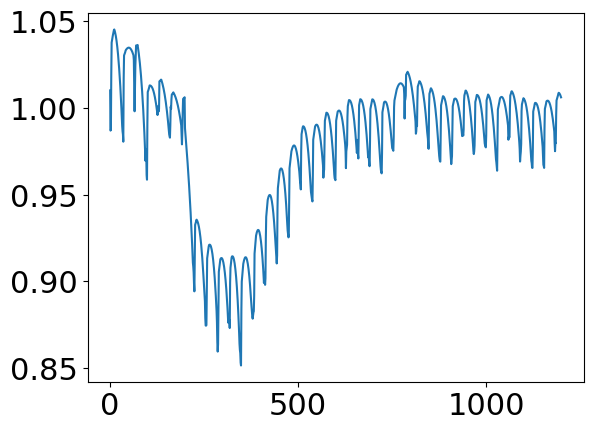

In [17]:
plt.plot( np.array(sim_results['v0']))
plt.show()

## initialize the variables and system matrices





In [18]:
# Frequency Control Porblem Environment
class Voltage(gym.Env):
    def  __init__(self, Matrix_X,Matrix_R, max_action,dim_action,Penalty_action):
        self.param_gamma=1
        self.Matrix_X = Matrix_X.astype(np.float32)
        self.Matrix_R = Matrix_R.astype(np.float32)
        self.inv_Matrix_X = LA.inv(Matrix_X).astype(np.float32)
        self.lambda_max = np.max(LA.eigvals(Matrix_X))
        self.max_action = max_action.astype(np.float32)
        self.dim_action=dim_action
        self.delta_t = 1
        self.state=[]
        self.Penalty_action=Penalty_action


    def step(self, action):
        # action=K.dot(self.Multiply_V_ref-K.dot(prev_output, self.select_V),tf.linalg.diag(Vector_A))
        # integrate the state transition dynamics

        self.state=(self.state-action@(self.Matrix_X.T)).copy()
        # loss = self.param_gamma*np.sum(abs(self.V_ref.T-self.state@self.select_V))
        return self.state

    def step_varyingP(self, action, Pt):


        self.state=(self.state-action@(self.Matrix_X.T)+Pt@(self.Matrix_R.T)).copy()
        return self.state

    def set_state(self, state_input):
        self.state=state_input


    def reset(self):
        self.state = np.random.uniform(-1,1,(1,self.dim_action)).astype(np.float32)

        return self.state



In [19]:
# Paramters for Lindisflow
Matrix_R=2*R_matrix
Matrix_X=2*X_matrix
dim_action=np.shape(Matrix_X)[0]
V_ref=np.ones((dim_action,1))
P_ref=np.mean(sim_results['p_nominal'][0:100],axis=1).reshape((-1,1))
X = Matrix_X

Penalty_action=0.1
max_action= sim_results['q_max'][:,1]
Q_ref = -1*(LA.inv(Matrix_X))@Matrix_R@P_ref
env = Voltage(Matrix_X,Matrix_R, max_action,dim_action,Penalty_action)


In [20]:
lambda_max = np.max(LA.eigvals(Matrix_X))
print(LA.eigvals(Matrix_X))
2/lambda_max

[0.025 0.    0.001 0.011 0.005 0.004 0.008 0.003 0.009 0.013 0.013 0.007 0.007]


np.float64(79.76480701292775)

# CVX

## Bounds for linear coefficients

In [22]:
Matrix_X_inv=np.linalg.inv(Matrix_X)
Matrix_R_inv=np.linalg.inv(Matrix_R)

In [23]:
ratio_q = 0.5
K_bound=cp.Variable(dim_action,nonneg =True)
objective = cp.Maximize(cp.sum(cp.log(K_bound)))
diag_K_bound = cp.diag(K_bound)
constraints = [(diag_K_bound -ratio_q*2*Matrix_X_inv)<<0,diag_K_bound>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print('status',prob.status)
K_bound_q=np.array(K_bound.value)

ratio_p = 1 - ratio_q
K_bound=cp.Variable(dim_action,nonneg =True)
objective = cp.Maximize(cp.sum(cp.log(K_bound)))
diag_K_bound = cp.diag(K_bound)
constraints = [(diag_K_bound -ratio_p*2*Matrix_R_inv)<<0,diag_K_bound>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print('status',prob.status)
K_bound_p=np.array(K_bound.value)

print('K_bound_p', K_bound_p)
print('K_bound_q', K_bound_q)

status optimal
status optimal
K_bound_p [988.423 728.603 638.527 638.527 620.253 549.726 477.446 560.664 519.744 549.726 539.283 477.446 571.55 ]
K_bound_q [127.861  77.311  52.619  52.619  49.013  35.08   29.072  39.298  29.072  35.08   39.298  29.072  39.298]


# Init Simulation

In [24]:
#linear droop control
def Action_linear(state,linear_coff):
    action_nonconstrain = state*linear_coff
    action=action_nonconstrain
    # env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action


In [44]:

linear_coffp= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.01
linear_coffq= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.01
action_units=dim_action

### With V0 after fault, time-varying p

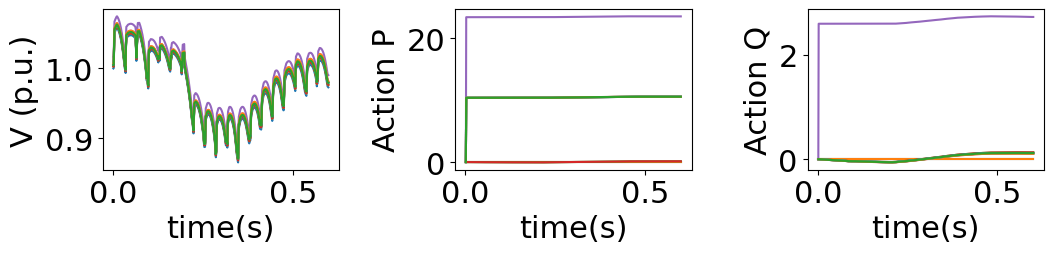

In [45]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 0.001
Q = 1*Q_ref.reshape((1,-1))
P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T

record_v0 = sim_results['v0']
q_min = 1*sim_results['q_min'][:,1]
q_max = 1*sim_results['q_max'][:,1]
s_concate=P@Matrix_R.T+Q@Matrix_X.T+ record_v0[0]
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=600
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear = []
Record_up_Linear.append(np.zeros(dim_action))
Record_uq_Linear.append(np.zeros(dim_action) )
Record_Loss_Linear=[]
Loss_Linear=0
for i in range(1,SimulationLength):
    up=np.squeeze(Action_linear(s-1,linear_coffp))
    uq=np.squeeze(Action_linear(s-1,linear_coffq))
    p = Record_up_Linear[-1]- up
    q = Record_uq_Linear[-1]- uq
    q = np.minimum(np.maximum(q, q_min), q_max)
    p = np.minimum(np.maximum(p, p_min), p_max)
    next_s=record_v0[i]+q@Matrix_X+p@Matrix_R
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(p.copy())
    Record_uq_Linear.append(q.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


# Training -q

In [27]:
class RNNModel(tf.keras.Model):
    def __init__(self, cell):
        super().__init__()
        self.rnn = tf.keras.layers.RNN(cell, return_sequences=True, stateful=True)

    def call(self, inputs, initial_state=None):
        return self.rnn(inputs, initial_state=initial_state)

In [28]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCellLinear0(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,K_boundq, K_boundp,sim_results,**kwargs):
        self.units = units
        self.action_units = action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.Matrix_X=tf.constant(env.Matrix_X,dtype=tf.float32)
        self.Matrix_R=tf.constant(env.Matrix_R,dtype=tf.float32)
        self.inv_Matrix_X = tf.constant(env.inv_Matrix_X,dtype=tf.float32)
        self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.p_min=tf.constant(sim_results['p_min'][:,1],dtype=tf.float32)
        self.p_max=tf.constant(sim_results['p_max'][:,1],dtype=tf.float32)
        self.q_min=tf.constant(sim_results['q_min'][:,1],dtype=tf.float32)
        self.q_max=tf.constant(sim_results['q_max'][:,1],dtype=tf.float32)
        self.bound_slopq = tf.constant(K_boundq.reshape((1,-1)),dtype=tf.float32)
        self.bound_slopp = tf.constant(K_boundp.reshape((1,-1)),dtype=tf.float32)
        self.norm_q=1
        super(MinimalRNNCellLinear0, self).__init__(**kwargs)

    def build(self, input_shape):


        self.linear_Kq= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kq')
        self.built = True

    def call(self, inputs_concate, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units]
        prev_state_q =  prev_state[:,self.action_units:2*self.action_units]
        prev_state_p =  prev_state[:,2*self.action_units:3*self.action_units]
        inputs_p = inputs_concate[:,0:self.action_units]
        inputs_v0 = inputs_concate[:,self.action_units:self.action_units+1]


        linear_Kq_=tf.math.minimum(self.linear_Kq, self.bound_slopq )
        action_q0= K.sum(tf.linalg.diag(prev_state_x)*linear_Kq_,axis=2)
        action_q = tf.minimum(tf.maximum(action_q0, self.q_min), self.q_max)
        new_state_x=prev_state_x-K.dot(action_q, tf.transpose(self.Matrix_X))+ K.dot(inputs_p, tf.transpose(self.Matrix_R)) + K.dot(inputs_v0, tf.ones((1,self.action_units)))
        new_state_q = prev_state_q - action_q

        next_state =  tf.concat([new_state_x, new_state_q], axis = 1)


        return [new_state_x,action_q, new_state_q], [next_state]




In [29]:
episodes =1200 # total number of iterations to update weights
action_units=dim_action
units=action_units*2 #dimension of each state
internal_units=20 # demension of the neural network for control policy
centralized_ctrl_cost_p = 1e-4 * np.array([1, 1, 0.5, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2]).reshape((-1,1))
centralized_ctrl_cost_q = 1e-5 * np.array([1, 1, 0.5, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2]).reshape((-1,1))
T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.03
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p,sim_results)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

Length_pred_dataset = sim_results['v0'].shape[0]-100
column1_idx = np.arange(0,dim_action)
PrintUpdate = 1
for i in range(0,episodes):
    initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Batch_num,action_units)))*(Q_ref.T)
    initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Batch_num,action_units)))*(P_ref.T)
    initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

    Input_config = np.zeros((Batch_num,T,dim_action+1))
    for j in range(Batch_num):
       #### time varying p
       t_init_Pm = np.random.randint(0, Length_pred_dataset-T-1)
       Input_config[j,:,:dim_action]=np.zeros((T,dim_action))
       ###### v0
       Input_config[j,:,dim_action] = np.diff(sim_results['v0'][t_init_Pm:t_init_Pm+T+1])

    with tf.GradientTape(persistent=True) as tape:
        [voltage,action_q, record_q]=modelLinear0(Input_config, np.hstack((initial_state, initial_state_q)))
        loss_voltage=K.sum(K.sum(K.abs(voltage)))/Batch_num/T/dim_action
        loss_action=0.001*K.sum(tf.matmul(record_q**2, centralized_ctrl_cost_q))/Batch_num/T/dim_action
        loss=loss_voltage+loss_action
    grads = tape.gradient(loss, modelLinear0.variables)
    optimizer.apply_gradients(zip(grads, modelLinear0.variables))
    Loss_record.append(loss)



    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss)
        print('         Loss_Voltage',loss_voltage, '  loss_action', loss_action)



episode 0 Loss tf.Tensor(0.1844335, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(0.18425594, shape=(), dtype=float32)   loss_action tf.Tensor(0.0001775666, shape=(), dtype=float32)


KeyboardInterrupt: 

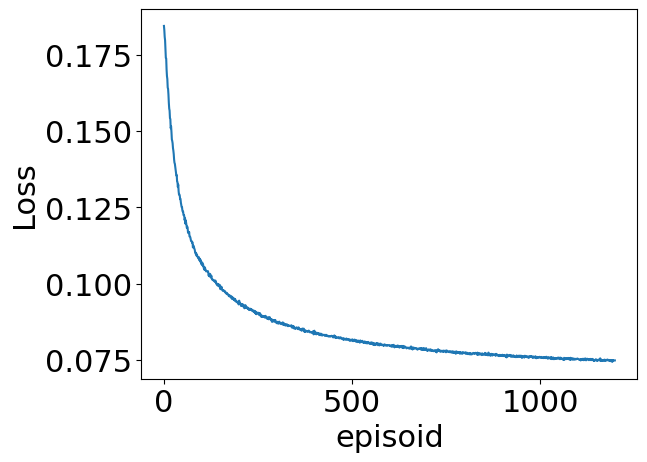

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.show()
# plt.title('Non-Discounted Loss without penalty')

In [31]:
modelLinear0.variables[0].numpy()

array([[0.427, 0.387, 9.647, 9.467, 0.442, 7.123, 6.491, 7.469, 6.016, 7.055, 7.46 , 6.259, 7.795]], dtype=float32)

# Training - pg

In [33]:
class RNNModel(tf.keras.Model):
    def __init__(self, cell):
        super().__init__()
        self.rnn = tf.keras.layers.RNN(cell, return_sequences=True, stateful=True)

    def call(self, inputs, initial_state=None):
        return self.rnn(inputs, initial_state=initial_state)

In [35]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCellLinear0(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,K_boundq, K_boundp,sim_results,**kwargs):
        self.units = units
        self.action_units = action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.Matrix_X=tf.constant(env.Matrix_X,dtype=tf.float32)
        self.Matrix_R=tf.constant(env.Matrix_R,dtype=tf.float32)
        self.inv_Matrix_X = tf.constant(env.inv_Matrix_X,dtype=tf.float32)
        self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.p_min=tf.constant(sim_results['p_min'][:,1],dtype=tf.float32)
        self.p_max=tf.constant(sim_results['p_max'][:,1],dtype=tf.float32)
        self.q_min=tf.constant(sim_results['q_min'][:,1],dtype=tf.float32)
        self.q_max=tf.constant(sim_results['q_max'][:,1],dtype=tf.float32)
        self.bound_slopq = tf.constant(K_boundq.reshape((1,-1)),dtype=tf.float32)
        self.bound_slopp = tf.constant(K_boundp.reshape((1,-1)),dtype=tf.float32)
        self.norm_q=1
        super(MinimalRNNCellLinear0, self).__init__(**kwargs)

    def build(self, input_shape):
        self.linear_Kp= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.3),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kp')

        self.linear_Kq= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kq')
        self.built = True

    def call(self, inputs_concate, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units]
        prev_state_q =  prev_state[:,self.action_units:2*self.action_units]
        prev_state_p =  prev_state[:,2*self.action_units:3*self.action_units]
        inputs_p = inputs_concate[:,0:self.action_units]
        inputs_v0 = inputs_concate[:,self.action_units:self.action_units+1]


        linear_Kq_=tf.math.minimum(self.linear_Kq, self.bound_slopq )
        linear_Kp_=tf.math.minimum(self.linear_Kp, self.bound_slopp )
        action_q0= K.sum(tf.linalg.diag(prev_state_x)*linear_Kq_,axis=2)
        action_p0= K.sum(tf.linalg.diag(prev_state_x)*linear_Kp_,axis=2)
        action_q = tf.minimum(tf.maximum(action_q0, self.q_min), self.q_max)
        action_p = tf.minimum(tf.maximum(action_p0, self.p_min), self.p_max)
        new_state_x=prev_state_x-K.dot(action_q, tf.transpose(self.Matrix_X))-K.dot(action_p, tf.transpose(self.Matrix_R))+ K.dot(inputs_p, tf.transpose(self.Matrix_R)) + K.dot(inputs_v0, tf.ones((1,self.action_units)))
        new_state_q = prev_state_q - action_q
        new_state_p = prev_state_p - action_p

        next_state =  tf.concat([new_state_x, new_state_q, new_state_p], axis = 1)


        return [new_state_x,action_q, action_p, new_state_q, new_state_p], [next_state]




In [36]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*3 #dimension of each state
internal_units=20 # demension of the neural network for control policy
centralized_ctrl_cost_p = 1e-4 * np.array([1, 1, 0.5, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2]).reshape((-1,1))
centralized_ctrl_cost_q = 1e-5 * np.array([1, 1, 0.5, 0.5, 10, 2, 2, 2, 2, 2, 2, 2, 2]).reshape((-1,1))
T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.02
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p,sim_results)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

Length_pred_dataset = sim_results['v0'].shape[0]-100
column1_idx = np.arange(0,dim_action)
PrintUpdate = 1
for i in range(0,episodes):
    initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Batch_num,action_units)))*(Q_ref.T)
    initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Batch_num,action_units)))*(P_ref.T)
    initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

    Input_config = np.zeros((Batch_num,T,dim_action+1))
    for j in range(Batch_num):
       #### time varying p
       t_init_Pm = np.random.randint(0, Length_pred_dataset-T-1)
       Input_config[j,:,:dim_action]=np.zeros((T,dim_action))
      #  p_inj_diff[t_init_Pm:t_init_Pm+T,:]
       ###### v0
       Input_config[j,:,dim_action] = np.diff(sim_results['v0'][t_init_Pm:t_init_Pm+T+1])


    with tf.GradientTape(persistent=True) as tape:
        [voltage,action_q,action_p, record_q, record_p]=modelLinear0(Input_config, np.hstack((initial_state, initial_state_q, initial_state_p)))
        loss_voltage=K.sum(K.sum(K.abs(voltage)))/Batch_num/T/dim_action
        loss_action_q=0.001*K.sum(tf.matmul(record_q**2, centralized_ctrl_cost_q))/Batch_num/T/dim_action
        loss_action_p=0.001*K.sum(tf.matmul(record_p**2, centralized_ctrl_cost_p))/Batch_num/T/dim_action
        loss_action=loss_action_q+loss_action_p
        loss=loss_voltage+loss_action
    grads = tape.gradient(loss, modelLinear0.variables)
    optimizer.apply_gradients(zip(grads, modelLinear0.variables))
    Loss_record.append(loss)



    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss)
        print('         Loss_Voltage',loss_voltage, '  loss_action', loss_action)
        print('         loss_action_p', loss_action_p, 'loss_action_q', loss_action_q)



episode 0 Loss tf.Tensor(0.977529, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(0.79632336, shape=(), dtype=float32)   loss_action tf.Tensor(0.18120562, shape=(), dtype=float32)
         loss_action_p tf.Tensor(0.18102671, shape=(), dtype=float32) loss_action_q tf.Tensor(0.00017889615, shape=(), dtype=float32)


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

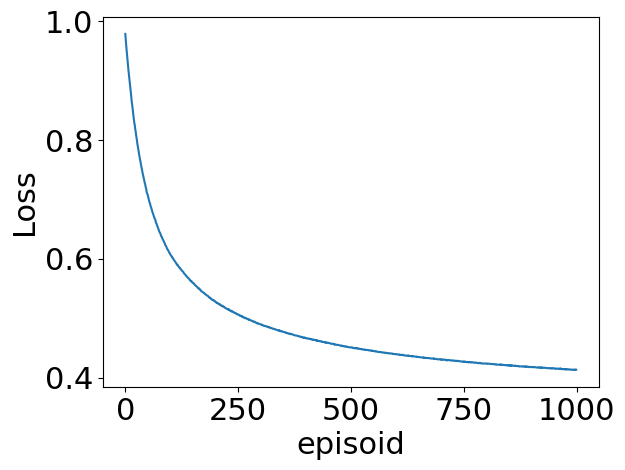

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
# plt.title('Non-Discounted Loss without penalty')

In [55]:
modelLinear0.variables

[<Variable path=rnn_model_1/rnn_1/minimal_rnn_cell_linear0_1/linear_Kp, shape=(1, 13), dtype=float32, value=[[0.187 0.257 6.581 6.62  0.212 0.15  0.231 0.142 0.18  0.169 0.205 0.285 0.142]]>,
 <Variable path=rnn_model_1/rnn_1/minimal_rnn_cell_linear0_1/linear_Kq, shape=(1, 13), dtype=float32, value=[[0.366 0.213 6.535 6.431 0.391 5.235 5.074 5.796 5.081 5.273 5.674 5.193 5.919]]>]